In [24]:
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import scipy as sci
import seaborn as sns

import datetime
import autogenes as ag

import matplotlib as mpl

In [2]:
#select replicate indices and save their sum
def removeReplicas(adata):
    #find genes with a '.' in their name
    noreplica = adata.var.loc[~adata.var.index.str.contains("\\."),:].index
    print(adata[:,noreplica])
    replicas = adata.var.loc[adata.var.index.str.contains("\\."),:].index
    uniques = set()
    new_var_names = set()
    for x in replicas: 
        uniques.add(x.split(".")[0])
        new_var_names.add(x.split(".")[0])
    new_var_names.update(noreplica.tolist())
    adata_new = sc.AnnData(np.zeros((len(adata.obs_names),len(new_var_names))))
    adata_new.var_names = list(new_var_names)
    adata_new.obs_names = adata.obs_names
    adata_new[:,noreplica].X = adata[:,noreplica].X
    adata_new.obs = adata.obs
    for x in uniques:
        ind = adata.var.loc[adata.var.index.str.contains(x),:].index
        if(len(ind)!=1):
            adata_new[:,x].X = np.sum(adata[:,ind].X,axis=1)
        else:
            adata_new[:,x].X =  adata[:,ind[0]].X
    return adata_new

In [3]:
def normalize_proportions(data,copy):
    if copy==True:
        data_copy = data.copy()
    else:
        data_copy = data
    data_copy[data_copy < 0] = 0
    for raw in data_copy.index:
        sum = data_copy.loc[raw].sum()
        if sum!=0:
            data_copy.loc[raw] = np.divide(data_copy.loc[raw],sum)
        else:
            data_copy.loc[raw] = 0
    return data_copy

Data to train the model from here:
https://singlecell.broadinstitute.org/single_cell/study/SCP253/allergic-inflammatory-memory-in-human-respiratory-epithelial-progenitor-cells?scpbr=the-alexandria-project

In [4]:
adata = sc.read_text('../data/20180921_PolypScrape_cleaned_data.txt', delimiter='\t').T

In [18]:
meta_data = pd.read_csv('../data/np_alexandria_meta_with_sss.csv', sep=',', index_col=0)

/projects/b1038/Pulmonary/nmarkov/pediatric-covid/code/.venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (6,10,11,16,17,33,35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
adata.X = np.expm1(adata.X)

In [9]:
len(np.intersect1d(meta_data.index, adata.obs_names))

18704

In [14]:
meta_data = meta_data.drop('TYPE',axis=0)
meta_data = meta_data.loc[adata.obs_names,:]

In [15]:
for s in meta_data.columns.values:
    adata.obs[s] = meta_data[s].tolist()

Supplementary tables from https://www.nature.com/articles/s41586-018-0449-8#Sec24

In [12]:
abulks = sc.read_text('../data/SuppTable11_PolypBulk_TPMData.txt').T

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [13]:
abulks.var_names_make_unique()
abulks_proc = abulks.copy()
#abulks_proc.X = abulks_proc.X.todense()
abulks_proc = removeReplicas(abulks_proc)

View of AnnData object with n_obs × n_vars = 27 × 23683


In [14]:
meta_data_bulks = pd.read_csv('../data/SuppTable12_PolypBulk_MetaData_diag_KNN27.txt', sep='\t', index_col=0)

In [15]:
meta_data_bulks.columns

Index(['polyp', 'batch', 'KNNorder'], dtype='object')

In [16]:
meta_data_bulks = meta_data_bulks.loc[abulks_proc.obs_names,:]
print(np.all(abulks_proc.obs_names==meta_data_bulks.index))

for s in meta_data_bulks.columns.values:
    abulks_proc.obs[s] = meta_data_bulks[s].tolist()

True


In [17]:
adata_proc = adata.copy()

In [18]:
len(np.intersect1d(adata_proc.var_names, abulks_proc.var_names))

16978

In [19]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata_proc.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_proc, min_cells=20)
print('Number of genes after gene filter: {:d}'.format(adata_proc.n_vars))

Total number of genes: 24842


/projects/b1038/Pulmonary/nmarkov/pediatric-covid/code/.venv/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Number of genes after gene filter: 17167


In [20]:
#Filter genes:
print('Total number of genes: {:d}'.format(abulks_proc.n_vars))

# Min 1 cells - filters out 0 count genes
sc.pp.filter_genes(abulks_proc, min_cells=1)
print('Number of genes after gene filter: {:d}'.format(abulks_proc.n_vars))

Total number of genes: 23686
Number of genes after gene filter: 21042


In [21]:
sc.pp.normalize_per_cell(adata_proc, counts_per_cell_after=1e4,copy=False)
sc.pp.normalize_per_cell(abulks_proc, counts_per_cell_after=1e4,copy=False)

adata_proc = adata_proc[:,np.intersect1d(adata_proc.var_names,abulks_proc.var_names)]
abulks_proc = abulks_proc[:,np.intersect1d(adata_proc.var_names,abulks_proc.var_names)]

adata_log = sc.pp.log1p(adata_proc, copy=True)
abulks_log = sc.pp.log1p(abulks_proc, copy=True)

#sc.pp.scale(adata_log)

/projects/b1038/Pulmonary/nmarkov/pediatric-covid/code/.venv/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/projects/b1038/Pulmonary/nmarkov/pediatric-covid/code/.venv/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [22]:
n_top_genes = 5000
sc.pp.highly_variable_genes(adata_log, flavor='seurat', n_top_genes=n_top_genes)

In [23]:
sc.tl.pca(adata_log)
adata_log.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat

/projects/b1038/Pulmonary/nmarkov/pediatric-covid/code/.venv/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [24]:
sc.pp.neighbors(adata_log, n_neighbors=30)
sc.tl.umap(adata_log)

/projects/b1038/Pulmonary/nmarkov/pediatric-covid/code/.venv/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'species__ontology_label' as categorical
... storing 'polyp' as categorical
... storing 'disease__ontology_label' as categorical
... storing 'biosample_id' as categorical
... storing 'sex' as categorical
... storing 'organism_age' as categorical
... storing 'organ__ontology_label' as categorical
... storing 'cell_type__ontology_label' as categorical
... storing 'specialcells' as categorical
... storing 'ace2' as categorical
... storing 'biosample_type' as categorical
... storing 'preservation_method' as categorical
... storing 'cell_retreival_method' as categorical
... storing 'disease__treated' as categorical
... storing 'disease__treatment' as categorical
... storing 'seqwell_

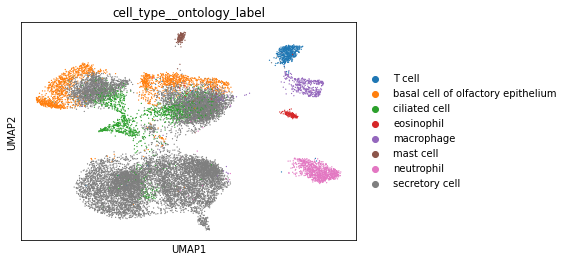

In [25]:
sc.pl.umap(adata_log,color='cell_type__ontology_label')

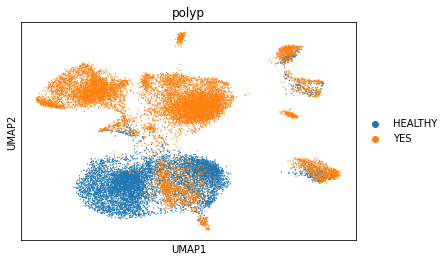

In [26]:
sc.pl.umap(adata_log, color='polyp')

In [27]:
shared_hv = np.intersect1d(
    adata_proc[
        :,
        adata_log.var_names[adata_log.var['highly_variable']==True]
    ].var_names,abulks_proc.var_names
)

/projects/b1038/Pulmonary/nmarkov/pediatric-covid/code/.venv/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [28]:
adata_hv = adata_proc[:,shared_hv].copy()

In [29]:
print(datetime.datetime.now())
time0 = datetime.datetime.now()

ngenes = 400 
ngen=5000
centroids = ag.init(adata_hv, use_highly_variable=False, celltype_key='cell_type__ontology_label')
ag.optimize(ngen=ngen, seed=0, nfeatures=ngenes, mode='fixed', verbose=False)

print(datetime.datetime.now()-time0)

2021-04-28 14:51:54.915082
0:13:21.322182


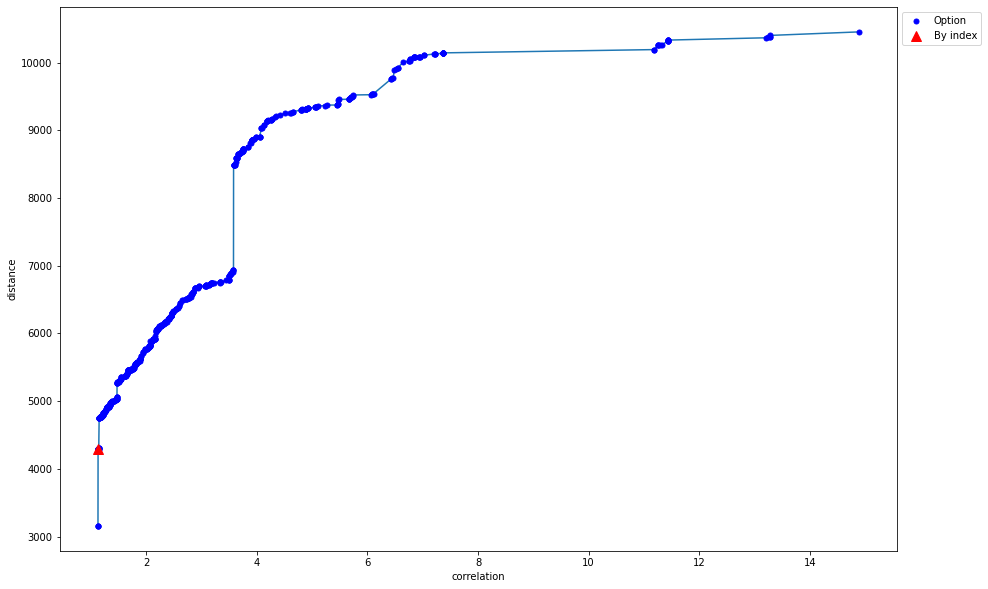

In [30]:
ag.plot(index=3)

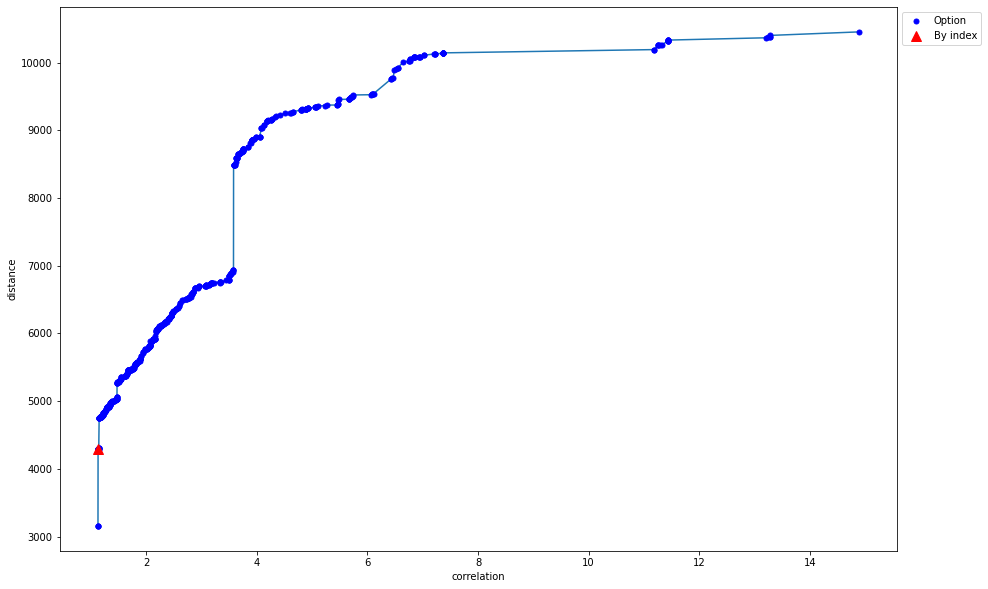

In [30]:
ag.plot(index=3)

In [31]:
pareto = 1
selection = ag.select(index=pareto)

centroids_sc_pareto = pd.DataFrame(centroids[:,selection].X.T,index=centroids[:,selection].var_names,columns=centroids[:,selection].obs_names)

/projects/b1038/Pulmonary/nmarkov/pediatric-covid/code/.venv/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


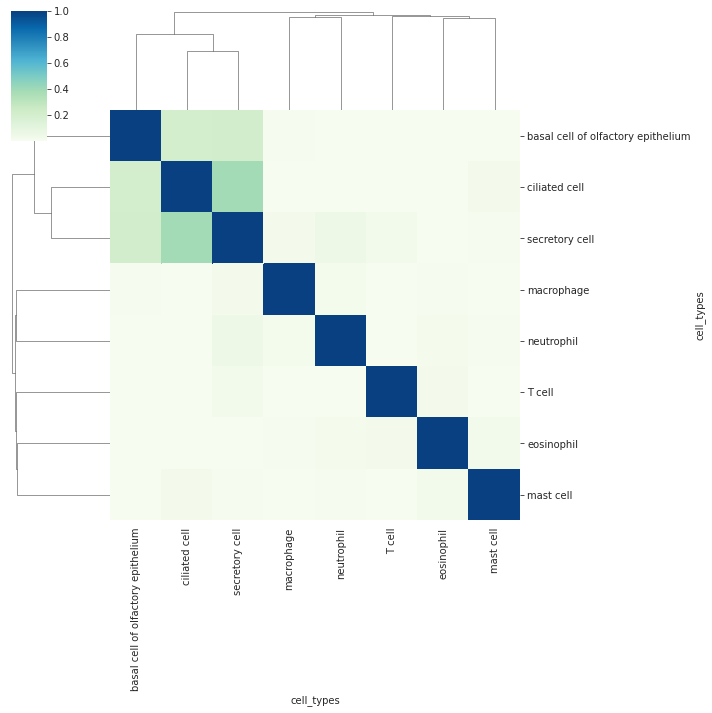

In [32]:
corr = pd.DataFrame(data = np.corrcoef(centroids_sc_pareto.T), columns = centroids_sc_pareto.columns, index = centroids_sc_pareto.columns)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot =sns.clustermap(np.abs(corr),cmap=sns.color_palette("GnBu", 1000), robust=True)

In [33]:
sorted_indicies = np.argsort(abulks_proc.obs['KNNorder'])

In [34]:
abulks_proc = abulks_proc[abulks_proc.obs.iloc[sorted_indicies].index]

In [35]:
abulks_hv = abulks_proc[:,shared_hv]

In [36]:
abulks_hv.shape

(27, 5000)

In [98]:
abulks_hv.X.sum(axis=1)

ArrayView([7194.1885, 5518.156 , 7197.715 , 7015.1377, 7147.19  ,
           6813.6045, 5483.624 , 5638.3203, 4523.818 , 4078.0723,
           6040.595 , 5314.6836, 7188.423 , 4433.8477, 6562.8154,
           5439.88  , 4445.497 , 5353.2734, 5941.877 , 6474.9053,
           5436.6626, 4451.332 , 4666.5083, 7185.698 , 5473.222 ,
           6889.2407, 8934.197 ], dtype=float32)

In [37]:
coef_nnls = ag.deconvolve(abulks_hv.X, model='nnls') #model='nusvr'
coef_nnls.shape

(27, 8)

In [38]:
proportions_nnls = pd.DataFrame(data=coef_nnls.T, index= centroids_sc_pareto.columns, columns = abulks_hv.obs_names)
proportions_nnls_norm = normalize_proportions(proportions_nnls.T,copy=True).T

In [39]:
proportions_nnls_norm = proportions_nnls_norm.set_index(proportions_nnls_norm.index)
proportions_nnls_norm=proportions_nnls_norm.astype(float)

In [40]:
proportions = proportions_nnls_norm.copy()#loc[:,real_prop.index]

In [41]:
proportions_nnls_norm.loc['sample',:] = 'HEALTHY'
for x in proportions_nnls_norm.columns:
    if abulks_hv.obs.loc[x,'polyp']=='yes':
        proportions_nnls_norm.loc['sample',x] = 'POLYP'

In [43]:
indices_non = [x for x in proportions_nnls_norm.columns if proportions_nnls_norm.loc['sample',x]=='HEALTHY']
indices_pol = [x for x in proportions_nnls_norm.columns if proportions_nnls_norm.loc['sample',x]=='POLYP']

Trying to set attribute `.obs` of view, copying.


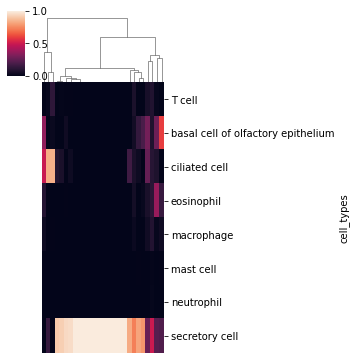

In [45]:
abulks_proc.obs['sample'] = proportions_nnls_norm.loc['sample',:]
abulks_proc.obs['order'] = np.linspace(1,len(abulks_proc.obs_names),len(abulks_proc.obs_names)).astype('int')
abulks_proc.layers['counts'] = abulks_proc.X
time = abulks_proc.obs['order'].values
time = time[np.isfinite(time)]
ax = sns.clustermap(proportions.loc[:,abulks_proc.obs_names], col_cluster=True, row_cluster=False,
                        xticklabels=False, figsize=(5,5))

In [32]:
sig_genes = centroids_sc_pareto.copy()

In [33]:
pd.DataFrame(sig_genes).sort_values(
    "macrophage", 
    ascending=False
).head(20)

cell_types,T cell,basal cell of olfactory epithelium,ciliated cell,eosinophil,macrophage,mast cell,neutrophil,secretory cell
HLA-DPB1,1.414752,0.157516,0.684400,2.431399,26.744774,0.412469,0.151927,0.302538
CXCL3,0.091004,0.258508,0.266444,0.000000,18.507126,0.039384,0.722035,0.459402
HLA-DQA1,0.393186,0.055645,0.334696,0.221818,11.094265,0.087188,0.099056,0.145462
CXCL5,0.015035,0.254960,0.044718,0.054158,10.864984,0.041642,0.072525,0.058564
HLA-DRB5,0.491529,0.100032,0.441215,0.644731,10.354685,0.181814,0.079020,0.322892
SPP1,0.000000,0.045916,0.171423,0.220698,8.086273,0.032841,0.324997,0.094034
C1QC,0.000000,0.016582,0.174802,0.000000,6.865906,0.119566,0.030727,0.071193
VCAN,0.016389,0.006246,0.092135,0.000000,6.845357,0.000000,0.106352,0.014025
SERPINB9,1.950628,0.038194,0.109704,0.259788,6.249549,1.866551,1.641653,0.103042
APOE,0.033316,0.006465,0.077770,0.000000,5.125099,0.635219,0.042856,0.109435


In [35]:
sig_genes.to_csv("01model-genes.csv")

## CF nasal samples

Data from https://reyfman-lab.github.io/2021-Sala/data.html via https://www.sciencedirect.com/science/article/pii/S1569199320309504

In [38]:
pbulk = pd.read_table(
    "Validation_cohort_raw_counts_relabeled_for_upload_with_genes.txt", 
    index_col=0
).T

In [39]:
pbulk.shape

(38, 56377)

In [45]:
pbulk = sc.AnnData(pbulk.iloc[1:-2, :], var=pbulk.iloc[:1, :].T, obs=pd.DataFrame(index=pbulk.index[1:-2]))

In [49]:
pbulk.var_names = pbulk.var.Gene_Name

In [51]:
pbulk.var_names_make_unique()
pbulk_proc = pbulk.copy()
pbulk_proc = removeReplicas(pbulk_proc)

View of AnnData object with n_obs × n_vars = 35 × 37545
    var: 'Gene_Name'


In [52]:
sc.pp.normalize_per_cell(pbulk_proc, counts_per_cell_after=1e4, copy=False)

In [53]:
absent = shared_hv[~np.isin(shared_hv, pbulk_proc.var_names)]

In [55]:
absent_zeros = np.zeros((pbulk_proc.shape[0], absent.size))

In [56]:
new_X = np.hstack([pbulk_proc.X, absent_zeros])

In [57]:
new_var = pd.concat([pbulk_proc.var, pd.DataFrame(index=absent)])

In [58]:
pbulk_proc2 = sc.AnnData(new_X, obs=pbulk_proc.obs, var=new_var)

In [59]:
absent

array(['AAED1', 'AARS', 'ACPP', 'ADCK3', 'ADORA3', 'ADPRHL2', 'ADRBK1',
       'ADRBK2', 'ADSSL1', 'AGPAT9', 'AHSA2', 'AMICA1', 'ANKRD32',
       'APITD1', 'ASUN', 'ATHL1', 'B3GALTL', 'BAIAP2-AS1', 'BRE',
       'BZRAP1-AS1', 'C10orf107', 'C10orf118', 'C10orf12', 'C10orf128',
       'C10orf54', 'C10orf68', 'C11orf30', 'C11orf35', 'C11orf63',
       'C11orf70', 'C11orf74', 'C12orf23', 'C12orf36', 'C12orf52',
       'C12orf68', 'C12orf74', 'C14orf142', 'C14orf159', 'C14orf169',
       'C14orf37', 'C15orf26', 'C16orf62', 'C16orf80', 'C17orf53',
       'C17orf62', 'C17orf72', 'C19orf59', 'C1orf101', 'C1orf110',
       'C1orf173', 'C1orf186', 'C1orf192', 'C1orf63', 'C1orf64',
       'C20orf112', 'C20orf26', 'C2orf40', 'C2orf43', 'C2orf62',
       'C2orf70', 'C4orf21', 'C4orf22', 'C4orf29', 'C4orf32', 'C5orf27',
       'C5orf42', 'C5orf54', 'C5orf55', 'C5orf56', 'C7orf10', 'C7orf60',
       'C7orf63', 'C8orf4', 'C8orf44', 'C9orf117', 'C9orf169', 'C9orf3',
       'C9orf66', 'C9orf89', 'C9orf9

In [60]:
pbulk_hv = pbulk_proc2[:, shared_hv]

/projects/b1038/Pulmonary/nmarkov/ped-covid/code/.venv/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [61]:
coef_nnls = ag.deconvolve(pbulk_hv.X, model='nnls') #model='nusvr'
coef_nnls.shape

(35, 8)

In [62]:
proportions_nnls = pd.DataFrame(data=coef_nnls.T, index= centroids_sc_pareto.columns, columns = pbulk_hv.obs_names)
proportions_nnls_norm = normalize_proportions(proportions_nnls.T,copy=True).T

In [63]:
proportions_nnls_norm = proportions_nnls_norm.set_index(proportions_nnls_norm.index)
proportions_nnls_norm=proportions_nnls_norm.astype(float)

In [64]:
proportions = proportions_nnls_norm.copy()#loc[:,real_prop.index]

In [29]:
sample_order = pd.read_csv(
    "02kmeans-sample-order.csv", 
    index_col=0, 
    names=["sample"],
    skiprows=1
)["sample"]

In [30]:
sample_order = sample_order.str.replace(".", "-")

In [28]:
row_order = """ciliated cell
secretory cell
basal cell of olfactory epithelium
T cell
mast cell
macrophage
eosinophil
neutrophil""".split("\n")

In [85]:
genotype_to_color = {
    "Control": "b",
    "F508del": (139/255, 0, 0),
    "CompHet": (205/255, 102/255, 0)
}
genotype = []
for sample in sample_order:
    for g in ["Control", "CompHet", "F508del"]:
        if g in sample:
            genotype.append(genotype_to_color[g])
            break

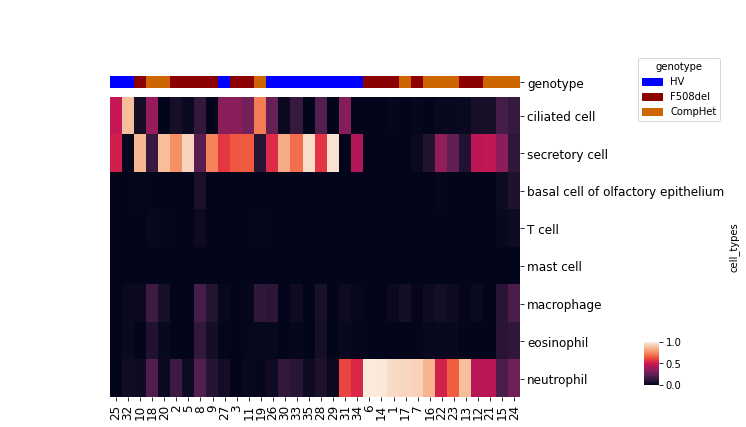

In [130]:
ax = sns.clustermap(
    proportions.loc[row_order, sample_order], 
    col_cluster=False, 
    row_cluster=False, 
    col_colors=genotype,
    xticklabels=sample_order.str.split("_").str[0],
    figsize=(10, 6),
    cbar_pos=(0.9, 0.1, 0.02, 0.1),
)
p = ax.ax_col_colors.get_position()
p.y0 += 0.02
p.y1 += 0.02
ax.ax_col_colors.set_position(p)
ax.ax_col_colors.set_yticks([0.5])
ax.ax_col_colors.set_yticklabels(["genotype"], fontsize=12)
ax.ax_col_colors.tick_params(labelleft=False, left=False, right=True, labelright=True)
ax.ax_heatmap.tick_params(axis="y", labelsize=12)
ax.ax_heatmap.tick_params(axis="x", rotation=90, labelsize=12)
ax.ax_col_colors.legend(
    [mpl.patches.Patch(color=x) for x in genotype_to_color.values()],
    ["HV", "F508del", "CompHet"],
    bbox_to_anchor=(1.5, 3),
    frameon=True,
    title="genotype"
)

In [131]:
ax.savefig("02deconv.pdf")

In [69]:
proportions.to_csv("02deconv-proportions.csv")

In [34]:
cfne_props = proportions.loc[row_order, sample_order]

In [36]:
cfne_props.columns = cfne_props.columns.str.split("_").str[0]

In [38]:
cfne_props.to_csv("02deconv-cf-nu-cohort.csv")